<h2><center>AI in Healthcare</center></h2>
<h3><center>Smart Home Activities Prediction</h3>

The objective of this lab is to learn to apply the LSTM to the data collectd from Halmstad University's Smart Home

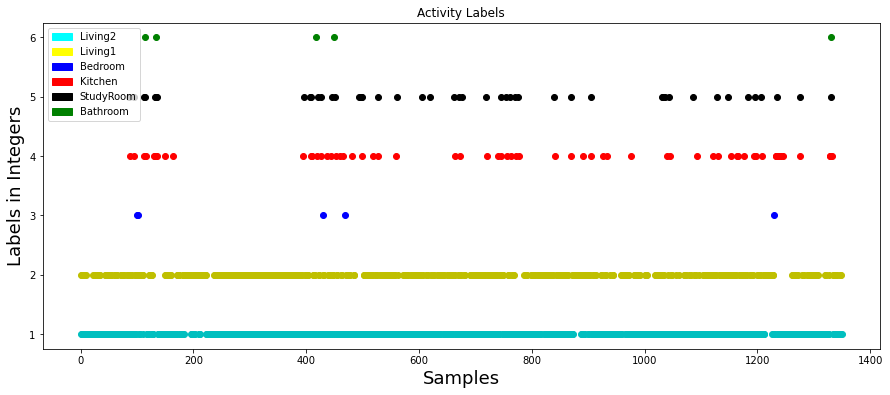

In [1]:
from scipy.io import loadmat
import numpy as np
from numpy import array
from pandas import DataFrame, concat
import os

data = loadmat(f"{os.getcwd()}/Data.mat")

DatesVectors = np.array(data['DatesVectors'])
SensorsVals = np.array(data['SensorsVals'])
Labels = np.array(data['Labels'])
Labels = Labels[7401:,:]

SensorsVals = SensorsVals.astype('int')
SensorsVals = SensorsVals[7401:,:]
SensorsVals = np.concatenate(SensorsVals,axis=0)

TrainLabels=Labels
TrainLabels=np.ravel(TrainLabels)
TrainLabels=np.array(TrainLabels)

Classes=['Living2','Living1','Bedroom','Kitchen','Study','Bathroom']
Indexes=[] # creat an empty list
for kk in range(len(Classes)):
    lbl=Classes[kk]
    idx=np.argwhere(TrainLabels==lbl)
    Indexes.append(idx)
    
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
Colors=['c','y','b','r','k','g']
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.title('Activity Labels')
for kk in range(len(Indexes)):
    idx=np.array(Indexes[kk])
    for jj in range(len(idx)):
        ax.plot(idx[jj],SensorsVals[idx[jj]],'o',color=Colors[kk],label=Classes[kk])
        
ax.set_ylabel('Labels in Integers',fontsize=18)
ax.set_xlabel('Samples',fontsize=18)

blue_patch = mpatches.Patch(color='blue', label='Bedroom')
red_patch = mpatches.Patch(color='red', label='Kitchen')
green_patch = mpatches.Patch(color='green', label='Bathroom')
cyan_patch = mpatches.Patch(color='cyan', label='Living2')
yellow_patch = mpatches.Patch(color='yellow', label='Living1')
black_patch = mpatches.Patch(color='black', label='StudyRoom')


ax.legend(handles=[cyan_patch,yellow_patch,blue_patch,red_patch,black_patch,green_patch])
plt.show()


## Instructions
You are supposed to do a sequence of integers prediction using LSTM.
First, try to visualize what you have in the SensorsVals. The values of SensorsVals are already concatanated into an array 
of integers.

You expose the LSTM to a sequence of observation. Then, the LSTM is going to do the prediciton of the sequence after some
training (sequence to sequence model).

You may try your own methodology. The suggestion is to:
- one hot encode the SensorsVals variables (encoded)
- Frame the encoded sequences for learning 




### Encoding

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
'''
With courtesy of https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
'''
labels = [label[0] for label in Labels]
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(labels_encoded)

/home/stud/j/jonfoc16/miniconda3/envs/aih/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Splitting data

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
'''
With courtesy of https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
'''
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
#x, y = split_sequence(labels_encoded, 5)

In [7]:
#print(f'Input sequence: {SensorsVals[:5]}\nCorresponding output sequence: {SensorsVals[5]}\n')
#print(f'Encoded input sequence: \n{x[0]}\nEncoded corresponding output sequence: {y[0]}')

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
split_percent = 0.80
split = int(split_percent*len(SensorsVals))

x_train = SensorsVals[:split]
x_test = SensorsVals[split:]

print(len(x_train))
print(len(x_test))

1080
270


In [10]:
train_generator = TimeseriesGenerator(x_train, x_train, length=5, batch_size=20)
test_generator = TimeseriesGenerator(x_test, x_test, length=5, batch_size=1)

### Construct LSTM model

LSTM info: </br>
 [samples, timesteps, features] - Input and output required format. </br>
 Samples= the amount of sequences. </br>
 Timesteps = Length of a given sequence.</br> 
 Features = Amount of separate values.
 
 Encoder outputs a 2D array. Decoder expects a 3D array as input

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, TimeDistributed, RepeatVector
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [12]:
sequence_length = 5
n_features = 6
def createLSTM():
    #model = Sequential(name='LSTM')
    #model.add(LSTM(units=10, input_shape=(sequence_length, n_features), return_sequences=True))
    #model.add(RepeatVector(sequence_length))
    #model.add(LSTM(units=10, return_sequences=True))
    #model.add(TimeDistributed(Dense(units=n_features, activation='softmax')))
    
    input_ = Input(shape=(sequence_length, 1))
    lstm1 = LSTM(units=10, activation='relu')(input_)
    #output_ = TimeDistributed(Dense(units=n_features, activation='softmax'))(lstm1) # When not using TimeseriesGenerator
    output_ = Dense(units=1, activation='softmax')(lstm1)
    
    model = Model(inputs=input_, outputs=output_, name='LSTM')
    
    return model

In [13]:
model = createLSTM()
model.compile(optimizer=Adam(learning_rate=0.0005, beta_1=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


### Train model

In [15]:
EPOCHS = 50

#model.fit(x_train, 
 #         y_train, 
  #        epochs=EPOCHS, 
   #       validation_data=(x_train, y_train)
    #     )
model.fit_generator(train_generator, 
          epochs=EPOCHS
         )


Epoch 1/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 2/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 3/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 4/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 5/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 6/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 7/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 8/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 9/50
54/54 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5665
Epoch 10/50
54/54 [==============================] - 1s 12ms/step - loss:

In [155]:
yhat = model.predict(x_test)
for true, predicted in zip(y_test, yhat):
    print(f'Predicted value: {predicted}\tActual value: {true}')


Predicted value: [0.04739884 0.0101636  0.03387873 0.30457813 0.58012855 0.02385216]	Actual value: [0. 0. 0. 0. 1. 0.]
Predicted value: [0.05090819 0.01057443 0.03441096 0.33593735 0.54365903 0.02451005]	Actual value: [0. 0. 0. 1. 0. 0.]
Predicted value: [0.04914541 0.01065913 0.03572249 0.3148776  0.5627721  0.02682329]	Actual value: [0. 0. 0. 1. 0. 0.]
Predicted value: [0.05142145 0.01226247 0.04142264 0.28403    0.5822283  0.02863513]	Actual value: [0. 0. 1. 0. 0. 0.]
Predicted value: [0.04782919 0.01031188 0.03383723 0.30907977 0.5750617  0.02388017]	Actual value: [0. 0. 0. 0. 1. 0.]
Predicted value: [0.04964284 0.0114008  0.03553553 0.2980245  0.58020955 0.02518679]	Actual value: [0. 0. 0. 0. 1. 0.]
Predicted value: [0.06459379 0.01788512 0.04850163 0.30423653 0.530992   0.03379091]	Actual value: [0. 0. 0. 0. 1. 0.]
Predicted value: [0.05156879 0.0120028  0.03675325 0.32908192 0.54507595 0.02551732]	Actual value: [0. 0. 0. 1. 0. 0.]
Predicted value: [0.0505082  0.0104385  0.034376